<a href="https://colab.research.google.com/github/nxf-emma/APS360-Artificial-Intelligence-Fundamentals/blob/main/camAlexNet_withemoji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:

   
import torch.nn as nn
import torch

# Modified from Tutorial 3a and lecture notes
class CNNalex(nn.Module):
    def __init__(self):
        super(CNNalex, self).__init__()
        # nn.Conv2d(256,300,5,2)
        self.conv1 = nn.Conv2d(256,300,3, padding = 2) # Modified to 3, in_channels, out_chanels, kernel_size
        self.bn1 = nn.BatchNorm2d(300)
        self.conv2 = nn.Conv2d(300,350,3)
        self.bn2 = nn.BatchNorm2d(350)

        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.fc1 = nn.Linear(350*2*2, 32) # Modified first parameter
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))#4
        x = F.relu(self.bn2(self.conv2(x)))#2
        x = x.view(-1, 350*2*2) # Modified size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


if __name__ == '__main__':
    bn_model = CNNalex()
    # x = torch.randn(1,1,48,48)
    # print('Shape of output = ',bn_model(x).shape)
    # print('No of Parameters of the BatchNorm-CNN Model =',bn_model.count_parameters())

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


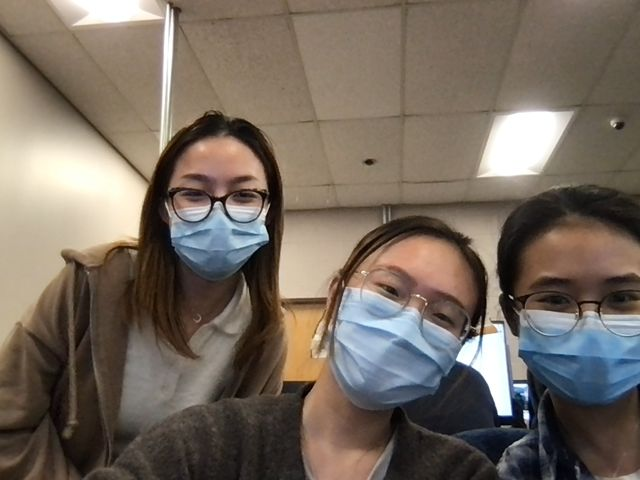

In [5]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [6]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [7]:
#
# based on: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
#

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np

def init_camera():
  """Create objects and functions in HTML/JavaScript to access local web camera"""

  js = Javascript('''

    // global variables to use in both functions
    var div = null;
    var video = null;   // <video> to display stream from local webcam
    var stream = null;  // stream from local webcam
    var canvas = null;  // <canvas> for single frame from <video> and convert frame to JPG
    var img = null;     // <img> to display JPG after processing with `cv2`

    async function initCamera() {
      // place for video (and eventually buttons)
      div = document.createElement('div');
      document.body.appendChild(div);

      // <video> to display video
      video = document.createElement('video');
      video.style.display = 'block';
      div.appendChild(video);

      // get webcam stream and assing to <video>
      stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;

      // start playing stream from webcam in <video>
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // <canvas> for frame from <video>
      canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      //div.appendChild(input_canvas); // there is no need to display to get image (but you can display it for test)

      // <img> for image after processing with `cv2`
      img = document.createElement('img');
      img.width = video.videoWidth;
      img.height = video.videoHeight;
      div.appendChild(img);
    }

    async function takeImage(quality) {
      // draw frame from <video> on <canvas>
      canvas.getContext('2d').drawImage(video, 0, 0);

      // stop webcam stream
      //stream.getVideoTracks()[0].stop();

      // get data from <canvas> as JPG image decoded base64 and with header "data:image/jpg;base64,"
      return canvas.toDataURL('image/jpeg', quality);
      //return canvas.toDataURL('image/png', quality);
    }

    async function showImage(image) {
      // it needs string "data:image/jpg;base64,JPG-DATA-ENCODED-BASE64"
      // it will replace previous image in `<img src="">`
      img.src = image;
      // TODO: create <img> if doesn't exists, 
      // TODO: use `id` to use different `<img>` for different image - like `name` in `cv2.imshow(name, image)`
    }

  ''')

  display(js)
  eval_js('initCamera()')

def take_frame(quality=0.8):
  """Get frame from web camera"""

  data = eval_js('takeImage({})'.format(quality))  # run JavaScript code to get image (JPG as string base64) from <canvas>

  header, data = data.split(',')  # split header ("data:image/jpg;base64,") and base64 data (JPG)
  data = b64decode(data)  # decode base64
  data = np.frombuffer(data, dtype=np.uint8)  # create numpy array with JPG data

  img = cv2.imdecode(data, cv2.IMREAD_UNCHANGED)  # uncompress JPG data to array of pixels

  return img

def show_frame(img, quality=0.8):
  """Put frame as <img src="data:image/jpg;base64,...."> """

  ret, data = cv2.imencode('.jpg', img)  # compress array of pixels to JPG data

  data = b64encode(data)  # encode base64
  data = data.decode()  # convert bytes to string
  data = 'data:image/jpg;base64,' + data  # join header ("data:image/jpg;base64,") and base64 data (JPG)

  eval_js('showImage("{}")'.format(data))  # run JavaScript code to put image (JPG as string base64) in <img>
                                           # argument in `showImage` needs `" "` 

In [8]:
# 
# based on: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=zo9YYDL4SYZr
#

#from google.colab.patches import cv2_imshow  # I don't use it but own function `show_frame()`

import cv2
import os

face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))

# init JavaScript code
init_camera()

while True:
    try:
        img = take_frame()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #cv2_imshow(gray)  # it creates new image for every frame (it doesn't replace previous image) so it is useless
        #show_frame(gray)  # it replace previous image

        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
                cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # cv2_imshow(img)  # it creates new image for every frame (it doesn't replace previous image) so it is useless
        show_frame(img)  # it replace previous image
        
    except Exception as err:
        print('Exception:', err)

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [9]:
model = CNNalex()
model.load_state_dict(torch.load('/content/drive/MyDrive/APS360 Team/model checkpoint/check_point_resampling_Alexnet3.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import os
from google.colab.patches import cv2_imshow
# from IPython.display import Image
# from Tkinter import *

# from model import *


# def load_trained_model(model_path):
#     model = CNNalex()
#     model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#     # model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
#     return model

from math import factorial
from skimage.measure import block_reduce
from PIL import Image
classes =['angry','fear', 'happy', 'neutral', 'sad', 'surprise']
alexnet = torchvision.models.alexnet(pretrained=True)

def get_emotion(img):
    w, h, c = img.shape
    # print("original: ", img.shape)
    if w>=224:
        factor = w//224
        # remainder = w//factor - 224
        #print(remainder)
        new_im = block_reduce(img, (factor, factor, 1), func=np.mean)
        new_w, new_h, new_c= new_im.shape
        if new_w > 224:
            new_im = np.transpose(new_im, [2, 0, 1])
            #t = torch.from_numpy(new_im)
            # print(new_im.shape())
            t = torch.tensor(new_im, dtype=torch.float64)
            tr = transforms.Resize((224, 224))
            tg = transforms.Grayscale(3)
            new_im = tg(tr(t))

            im = alexnet.features(new_im.unsqueeze(0).float())
            # print(im.size())
            out = model(im.float())
            return (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
    #block_reduce(img, 10)

# def FER_live_cam():
#     alexnet = torchvision.models.alexnet(pretrained=True)
#     model = load_trained_model('/checkpoint_resampling_Alexnet.pth')
    
#     emotion_dict = {0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness',
#                     4: 'anger',  5: 'fear'}


#     val_transform = transforms.Compose([
#                                       # transforms.Resize((48,48)),
#         transforms.ToTensor()])

#     # cap = cv2.VideoCapture(0)
#     init_camera()
#     img = take_frame()
    
#     try:
#       filename = take_photo()
#       print('Saved to {}'.format(filename))
      
#       # Show the image which was just taken.
#       display(Image(filename))
#     except Exception as err:
#       # Errors will be thrown if the user does not have a webcam or if they do not
#       # grant the page permission to access it.
#       print(str(err))
#     frame = take_frame()

#     while True:
#         # ret, frame = cap.read()
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/APS360 Team/haarcascade_frontalface_default.xml')
#         faces = face_cascade.detectMultiScale(frame)
#         for (x, y, w, h) in faces:
#             cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
#             resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48), interpolation=cv2.INTER_AREA)
#             # resize_frame = cv2.resize(gray[y:y + h, x:x + w], (224,224), interpolation=cv2.INTER_AREA)
#             X = resize_frame/256
#             X = Image.fromarray((X))
#             # X = 

#             X = val_transform(X).unsqueeze(0)
#             # X = X[256,:,:]
#             # x[None, :, None, :] 
#             print(X.size())
#             X = X.view(1,256,48,48)
#             print(X.size())
#             # X = 
#             # X = alexnet.features(X)
#     # features = alexnet.features(imgs)

#             with torch.no_grad():
#                 model.eval()
#                 # X=X[None,256,:,:]
#                 # print(X.size())
#                 log_ps = model.cpu()(X)
#                 ps = torch.exp(log_ps)
#                 top_p, top_class = ps.topk(1, dim=1)
#                 pred = emotion_dict[int(top_class.numpy())]
#             cv2.putText(frame, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1)
        
#         cv2.imshow('frame', frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()



# if __name__ == "__main__":

#     FER_live_cam()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [11]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: true});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 480; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [57]:
from numpy.lib.function_base import hamming
from google.colab.patches import cv2_imshow

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    
    # get face bounding box for overlay
    
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      faces = img[y:y + h, x:x + w]
      #print(faces.shape)
      #cv2.imwrite(filename, faces)
      pred = get_emotion(faces)


      
      if pred is not None:

        # if (classes[pred[0]] == "sad"):
        emoji_i = cv2.imread('/content/drive/MyDrive/APS360 Team/emoji/48.jpeg')
        emoji_2 = cv2.resize(emoji_i, (h,w))
        # eomoji_2 = cv2.equalizeHist(emoji_2)
        # emoji_2 = emoji_2/255
        # emoji_2 = np.expand_dims(np.expand_dims(emoji_2, -1),0)
        
        emoji = cv2.cvtColor(emoji_2,cv2.COLOR_RGB2RGBA)
        # width =  w
        # height = h
        overlay = np.zeros((h,w,4),dtype = 'uint8')
        emoji_h,emoji_w,emoji_c = emoji.shape
        # print(emoji_c)
        # print(emoji_w)
        for i in range(0,emoji_h):
          for j in range(0,emoji_w):
            for k in range(0,emoji_c):

              if emoji[i,j][3] !=0:
                overlay[i,j][k] = emoji[i,j][k]
              #emoji = img[y:y + h, x:x + w]
        
        
        # cv2_imshow(overlay)
        # cv2.imwrite(emoji)
        emoji_pic = cv2.addWeighted(bbox_array[y:y+h, x:x+w],0,overlay[0:emoji_h, 0:emoji_w],1,4)
        # bbox_array[x:x+w,y:y+h] = emoji_pic 
        bbox_array[y:y+h, x:x+w] = emoji_pic 






        cv2.putText(bbox_array,classes[pred[0]],(x+30,y-20),0,2,(0,255,0), 2)
      if len(faces)>1:
        break

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    faces = img[y:y + h, x:x + w]
    
    #cv2.imwrite(filename, faces)

<IPython.core.display.Javascript object>

IndexError: ignored